In [32]:
import numpy as np
import sys
import os
import glob
import importlib
import math as m
import pickle as pickle
import seaborn as sns
import statistics
import pandas as pd
fmts = ['svg','pdf']
from scipy.stats import norm, wilcoxon, ttest_rel, friedmanchisquare, shapiro,f_oneway,friedmanchisquare,rankdata
import statsmodels.stats.multitest as smm
from scipy import signal, fft
from scipy.optimize import curve_fit, minimize
import scipy.interpolate as interp
import matplotlib # produce matlab-style plots
from matplotlib import animation as ani # animation
import matplotlib.pyplot as plt # Matlab-style plotting
from matplotlib import rcParams
matplotlib.rc('font',**{'size':20}) # increase font size on plots
matplotlib.rc('text',usetex=False) # use LaTeX to render symbols
matplotlib.rc('animation',html='html5') # render animation
font = {#'family' : 'normal',
        'weight' : 'ultralight',
        'size'   : 14}
matplotlib.rc('font', **font)
rcParams['axes.titlesize'] = 16
rcParams['font.weight'] = 'ultralight'
rcParams['font.family'] = 'sans-serif'
rcParams['mathtext.fontset'] = 'cm'
prop_cycle = plt.rcParams['axes.prop_cycle']
python_colors = prop_cycle.by_key()['color'] # python default color cycle

# auto reload modules
%load_ext autoreload
%autoreload 2
sys.path.append('C:\\Users\\amber\\Documents\\GitHub\\sensorimotor_fusion\\analysis\\Multimodal paper') # change this for your computer
# DATA_PATH = 'C:\\Users\\amber\\Documents\\GitHub\\sensorimotor_fusion' #change this for your computer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
from globalVars import *
from collect_data import findFilename, getrawdata, get_data, analyze
from analysis import *

In [34]:
print('data length = ',N)
print('primes = ',primes)
print('base freq = ',base_freq)
print('IX = ',IX)
print('Even_IX = ',Even_IX)
print('Odd_IX = ',Odd_IX)
print('freqs = ',freqs)
print('omegas = ',omegas)
print('T = ',T) # total time 40 seconds
print('t = ',t) # timestamps
print('fs = ',fs)
print('sample_period (dt)= ',dt)
print('xf = ',xf) # frequency domain x-axis, shape (N//2,)
print('Machine = ',M) # soM at stimulated freqs
print('scaleInput = ',scaleInput)
print('scaleOutputScreen = ',scaleOutputScreen)

data length =  2400
primes =  [ 2  3  5  7 11 13 17 19]
base freq =  0.05
IX =  [ 4  6 10 14 22 26 34 38]
Even_IX =  [ 6 14 26 38]
Odd_IX =  [ 4 10 22 34]
freqs =  [0.1  0.15 0.25 0.35 0.55 0.65 0.85 0.95]
omegas =  [0.62831853 0.9424778  1.57079633 2.19911486 3.45575192 4.08407045
 5.34070751 5.96902604]
T =  40
t =  [0.00000000e+00 1.66736140e-02 3.33472280e-02 ... 3.99666528e+01
 3.99833264e+01 4.00000000e+01]
fs =  60
sample_period (dt)=  0.016666666666666666
xf =  [0.0000e+00 2.5000e-02 5.0000e-02 ... 2.9925e+01 2.9950e+01 2.9975e+01]
Machine =  [-0.7169568 -1.14107219j -0.52958685-0.5619091j  -0.28840044-0.18360142j
 -0.17134712-0.0779164j  -0.07726649-0.02235881j -0.05656227-0.01384948j
 -0.03387172-0.00634218j -0.02730057-0.00457371j]
scaleInput =  0.04616974606700115
scaleOutputScreen =  0.25


# Load data

In [35]:
# with open('multimodal_data.pkl', 'wb') as file:
#     pickle.dump(ALLdata, file)

# Load the array from the file
with open('multimodal_data.pkl', 'rb') as file:
    Rs,Ds,MDs,Us,U0s,U1s,Ys,rs,ds,mds,us,u0s,u1s,ys,errors,Tur,Tu0r,Tu1r,Tud,Tu0d,Tu1d,Tyr,Tyd,F,B,F0,F1,B0,B1 = pickle.load(file)

In [36]:
print(Rs.shape) # subject x condition x trial x all freqs
print(rs.shape) # subject x condition x trial x timestamps
print(errors.shape) # subject x condition x trial

subject_num = Rs.shape[0]
condition_num = Rs.shape[1]
trial_num = Rs.shape[2]
print('subject_num = ',subject_num)
print('condition_num (alphas) = ',condition_num)
print('trial_num = ',trial_num)
alphas = np.array([0,0.25,0.5,0.75,1])
# conditions = ['0','0.25','0.5','0.75','1']
conditions = ['0','25','50','75','100']
# conditions = ['0:1','1:3','1:1','3:1','1:0']
# conditions = ['0:1','1:3','1:1','3:1','1:0']

(15, 5, 14, 2400)
(15, 5, 14, 2400)
(15, 5, 14)
subject_num =  15
condition_num (alphas) =  5
trial_num =  14


In [38]:
def stats_test(datas):
    # Compute residuals (observed - condition mean)
    residuals_0 = datas[0] - np.mean(datas[0])
    residuals_25 = datas[1] - np.mean(datas[1])
    residuals_50 = datas[2] - np.mean(datas[2])
    residuals_75 = datas[3] - np.mean(datas[3])
    residuals_100 = datas[4] - np.mean(datas[4])

    # Combine residuals from all conditions
    all_residuals = np.concatenate([residuals_0, residuals_25, residuals_50, residuals_75, residuals_100])

    # Perform Shapiro-Wilk test on residuals
    stat, p = shapiro(all_residuals)
    print(f'Shapiro-Wilk Test Statistic={stat:.4f}, p-value={p:.4f}')
    if p > 0.05:
        print("Residuals appear to be normally distributed (fail to reject H0).")
        stat, p = f_oneway(datas[0],datas[1],datas[2],datas[3],datas[4]) #see if p < 0.05, there is a significant difference
        print(f'One-way ANOVA Statistic={stat:.4f}, p-value={p:.4f}')
    else:
        print("Residuals are NOT normally distributed (reject H0).") 
         # Perform Friedman test
        stat, p = friedmanchisquare(datas[0],datas[1],datas[2],datas[3],datas[4])
        print(f'Friedman Test Statistic={stat:.4f}, p-value={p:.4f}') # If p < 0.05, there is a significant difference
        if p <= 0.05:
            print('Friedman Test: significant difference')
            # post hoc test with Wilcoxon signed-rank tests with Bonferroni correction
            comparisons = [
                ("25 vs. 0", datas[1], datas[0]),
                ("50 vs. 0", datas[2], datas[0]),
                ("75 vs. 0", datas[3], datas[0]),
                ("25 vs. 100", datas[1], datas[4]),
                ("50 vs. 100", datas[2], datas[4]),
                ("75 vs. 100", datas[3], datas[4])
            ]
            p_values = []
            for name, cond1, cond2 in comparisons:
                stat, p = wilcoxon(cond1, cond2)
                p_values.append(p)
            # Apply Bonferroni correction (dividing α by 6)
            corrected_p_values = smm.multipletests(p_values, method='bonferroni')[1]
            for (name, _, _), p_raw, p_corr in zip(comparisons, p_values, corrected_p_values):
                print(f'{name}: Raw p-value = {p_raw:.4f}, Bonferroni-corrected p-value = {p_corr:.4f}')
        else:
            print('Friedman Test: no significant difference')

# Bode plots

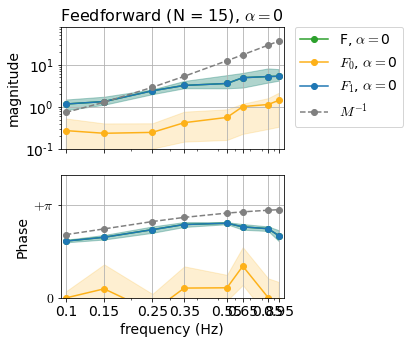

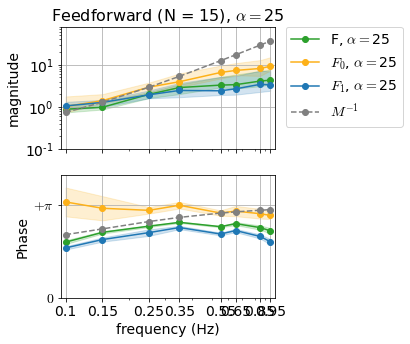

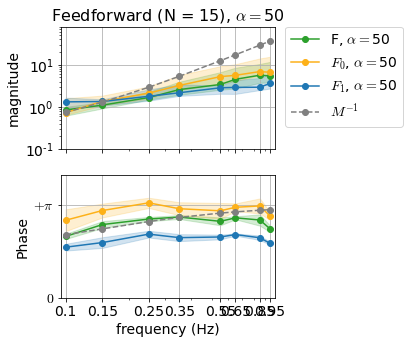

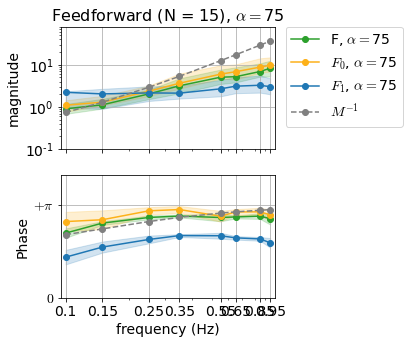

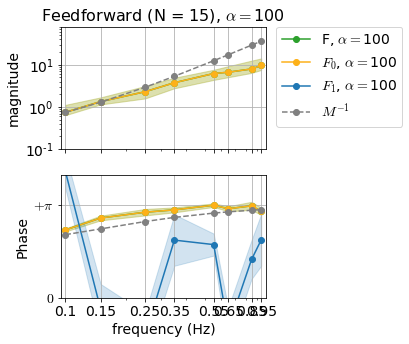

In [7]:
# Bode plot of F and B
xticks = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95])
xlim = (0.095, 1.0)
ylimphase = (0, np.pi+1)
yticksphase = [0.,np.pi]
yticklabelsphase = [r'$0$',r'$+\pi$']

for cond in range(condition_num):
    fig,axs = plt.subplots(2,1,sharex=True,figsize=(6,5))
    # F
    mean = np.mean(np.abs(F[:,cond,:,:]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(mean,[0.25,0.5,0.75],axis = 0)
    # magnitude
    ax = axs[0]
    ax.plot(freqs,q50,'-o',label = r'F, $\alpha = $'+conditions[cond],color = colors['GREEN'])
    ax.fill_between(freqs, q25, q75, alpha=0.2,color = colors['GREEN'])
    # phase
    ax = axs[1]
    F_angle = np.angle(np.mean(np.exp(1j*(np.angle(F[:,cond,:,:]))),axis = 1))
    z = np.mean(np.exp(1j*(F_angle-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-o',label = r'$\alpha = $'+conditions[cond],color = colors['GREEN'])
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['GREEN'])

    # F0
    F_mean = np.mean(np.abs(F0[:,cond,:,:]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(F_mean,[0.25,0.5,0.75],axis = 0)
    # magnitude
    ax = axs[0]
    ax.plot(freqs,q50,'-o',label = r'$F_0$, $\alpha = $'+conditions[cond],color = colors['GOLD'])
    ax.fill_between(freqs, q25, q75, alpha=0.2,color = colors['GOLD'])
    # phase
    ax = axs[1]
    F_angle = np.angle(np.mean(np.exp(1j*(np.angle(F0[:,cond,:,:]))),axis = 1))
    z = np.mean(np.exp(1j*(F_angle-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-o',label = r'$\alpha = $'+conditions[cond],color = colors['GOLD'])
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['GOLD'])

    # F1
    F_mean = np.mean(np.abs(F1[:,cond,:,:]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(F_mean,[0.25,0.5,0.75],axis = 0)
    # magnitude
    ax = axs[0]
    ax.plot(freqs,q50,'-o',label = r'$F_1$, $\alpha = $'+conditions[cond],color = colors['BLUE'])
    ax.fill_between(freqs, q25, q75, alpha=0.2,color = colors['BLUE'])
    # phase
    ax = axs[1]
    F_angle = np.angle(np.mean(np.exp(1j*(np.angle(F1[:,cond,:,:]))),axis = 1))
    z = np.mean(np.exp(1j*(F_angle-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-o',label = r'$\alpha = $'+conditions[cond],color = colors['BLUE'])
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['BLUE'])

    ax = axs[0]
    ax.plot(freqs,np.abs(1/M),'--o',color= 'grey',label = r'$M^{-1}$')
    ax.set_xscale("log")
    ax.set_xlim(xlim)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks,rotation=90) 
    ax.grid('on',zorder=-1)
    ax.set_ylim(0.1,80)
    ax.set_yscale("log")
    ax.set_ylabel('magnitude')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    ax = axs[1]
    ax.plot(freqs,np.angle(1/M),'--o',color= 'grey',label = r'$M^{-1}$')
    ax.set_ylabel('Phase') 
    ax.grid('on',zorder=-1)
    ax.set_ylim(ylimphase)
    ax.set_yticks(yticksphase)
    ax.set_yticklabels(yticklabelsphase)
    ax.set_xlabel('frequency (Hz)')
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    axs[0].set_title(r'Feedforward (N = 15), $\alpha = $'+conditions[cond])
    plt.tight_layout()
    plt.show()

# F0 and F1 in multimodal vs single-modal

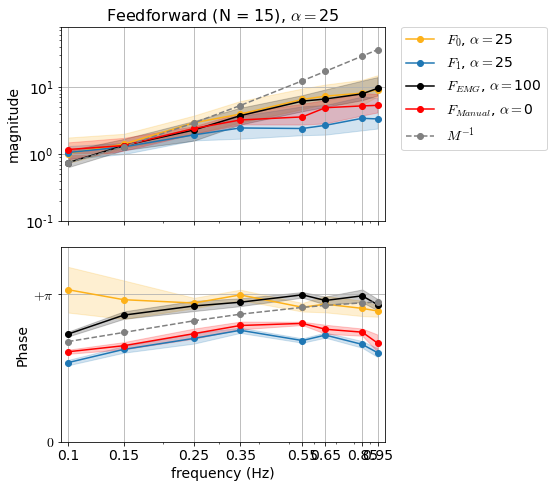

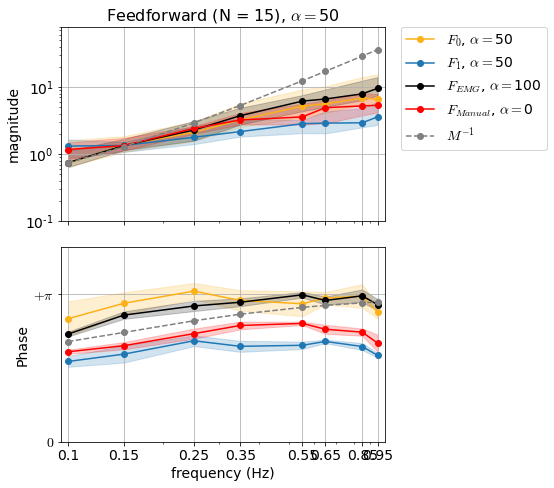

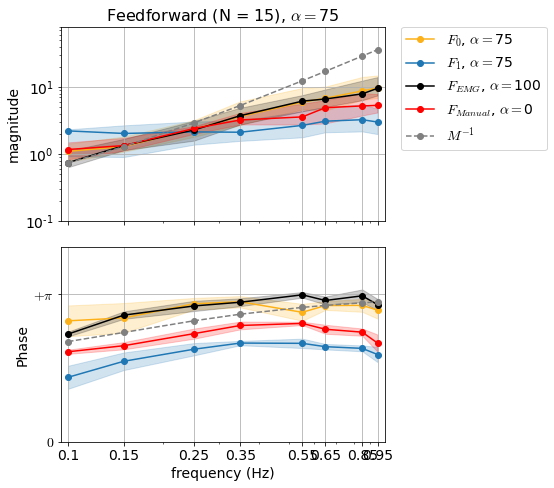

In [8]:
# Bode plot of F and B
xticks = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95])
xlim = (0.095, 1.0)
ylimphase = (0, np.pi+1)
yticksphase = [0.,np.pi]
yticklabelsphase = [r'$0$',r'$+\pi$']

for cond in [1,2,3]:

    fig,axs = plt.subplots(2,1,sharex=True,figsize=(8,7))


    # F0
    F_mean = np.mean(np.abs(F0[:,cond,:,:]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(F_mean,[0.25,0.5,0.75],axis = 0)
    # magnitude
    ax = axs[0]
    ax.plot(freqs,q50,'-o',label = r'$F_0$, $\alpha = $'+conditions[cond],color = colors['GOLD'])
    ax.fill_between(freqs, q25, q75, alpha=0.2,color = colors['GOLD'])
    # phase
    ax = axs[1]
    F_angle = np.angle(np.mean(np.exp(1j*(np.angle(F0[:,cond,:,:]))),axis = 1))
    z = np.mean(np.exp(1j*(F_angle-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-o',label = r'$\alpha = $'+conditions[cond],color = colors['GOLD'])
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['GOLD'])

    # F1
    F_mean = np.mean(np.abs(F1[:,cond,:,:]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(F_mean,[0.25,0.5,0.75],axis = 0)
    # magnitude
    ax = axs[0]
    ax.plot(freqs,q50,'-o',label = r'$F_1$, $\alpha = $'+conditions[cond],color = colors['BLUE'])
    ax.fill_between(freqs, q25, q75, alpha=0.2,color = colors['BLUE'])
    # phase
    ax = axs[1]
    F_angle = np.angle(np.mean(np.exp(1j*(np.angle(F1[:,cond,:,:]))),axis = 1))
    z = np.mean(np.exp(1j*(F_angle-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-o',label = r'$\alpha = $'+conditions[cond],color = colors['BLUE'])
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['BLUE'])

    # F_EMG-only
    F_mean = np.mean(np.abs(F0[:,4,:,:]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(F_mean,[0.25,0.5,0.75],axis = 0)
    # magnitude
    ax = axs[0]
    ax.plot(freqs,q50,'-o',label = r'$F_{EMG}$, $\alpha = $'+conditions[4],color = 'black')
    ax.fill_between(freqs, q25, q75, alpha=0.2,color = 'black')
    # phase
    ax = axs[1]
    F_angle = np.angle(np.mean(np.exp(1j*(np.angle(F0[:,4,:,:]))),axis = 1))
    z = np.mean(np.exp(1j*(F_angle-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-o',label = r'$\alpha = $'+conditions[4],color = 'black')
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = 'black')

    # F_Manual-only
    F_mean = np.mean(np.abs(F1[:,0,:,:]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(F_mean,[0.25,0.5,0.75],axis = 0)
    # magnitude
    ax = axs[0]
    ax.plot(freqs,q50,'-o',label = r'$F_{Manual}$, $\alpha = $'+conditions[0],color = 'red')
    ax.fill_between(freqs, q25, q75, alpha=0.2,color = 'red')
    # phase
    ax = axs[1]
    F_angle = np.angle(np.mean(np.exp(1j*(np.angle(F1[:,0,:,:]))),axis = 1))
    z = np.mean(np.exp(1j*(F_angle-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-o',label = r'$\alpha = $'+conditions[0],color = 'red')
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = 'red')

    ax = axs[0]
    ax.plot(freqs,np.abs(1/M),'--o',color= 'grey',label = r'$M^{-1}$')
    ax.set_xscale("log")
    ax.set_xlim(xlim)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks,rotation=90) 
    ax.grid('on',zorder=-1)
    ax.set_ylim(0.1,80)
    ax.set_yscale("log")
    ax.set_ylabel('magnitude')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    ax = axs[1]
    ax.plot(freqs,np.angle(1/M),'--o',color= 'grey',label = r'$M^{-1}$')
    ax.set_ylabel('Phase') 
    ax.grid('on',zorder=-1)
    ax.set_ylim(ylimphase)
    ax.set_yticks(yticksphase)
    ax.set_yticklabels(yticklabelsphase)
    ax.set_xlabel('frequency (Hz)')
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    axs[0].set_title(r'Feedforward (N = 15), $\alpha = $'+conditions[cond])
    plt.tight_layout()
    plt.show()

## separated

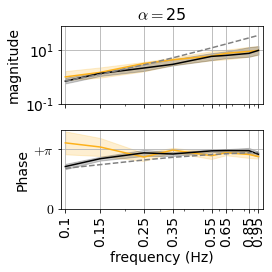

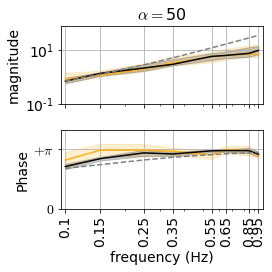

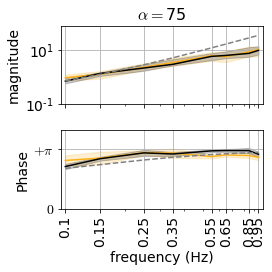

In [9]:
# Bode plot of F and B
xticks = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95])
xlim = (0.095, 1.0)
ylimphase = (0, np.pi+1)
yticksphase = [0.,np.pi]
yticklabelsphase = [r'$0$',r'$+\pi$']
last_few_trials = 5 # trial)num//2

for cond in [1,2,3]:
    fig,axs = plt.subplots(2,1,sharex=True,figsize=(4,4))

    # F0
    F_mean = np.mean(np.abs(F0[:,cond,-last_few_trials:,:]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(F_mean,[0.25,0.5,0.75],axis = 0) #across subjects
    # magnitude
    ax = axs[0]
    ax.plot(freqs,q50,'-',label = r'$F_0$, $\alpha = $'+conditions[cond],color = colors['GOLD'])
    ax.fill_between(freqs, q25, q75, alpha=0.2,color = colors['GOLD'])
    # phase
    ax = axs[1]
    F_angle = np.angle(np.mean(np.exp(1j*(np.angle(F0[:,cond,-last_few_trials:,:]))),axis = 1))
    z = np.mean(np.exp(1j*(F_angle-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-',label = r'$\alpha = $'+conditions[cond],color = colors['GOLD'])
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['GOLD'])

    # F_EMG-only
    F_mean = np.mean(np.abs(F0[:,4,-last_few_trials:,:]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(F_mean,[0.25,0.5,0.75],axis = 0)
    # magnitude
    ax = axs[0]
    ax.plot(freqs,q50,'-',label = r'$F_{EMG}$, $\alpha = $'+conditions[4],color = 'black')
    ax.fill_between(freqs, q25, q75, alpha=0.2,color = 'black')
    # phase
    ax = axs[1]
    F_angle = np.angle(np.mean(np.exp(1j*(np.angle(F0[:,4,-last_few_trials:,:]))),axis = 1))
    z = np.mean(np.exp(1j*(F_angle-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-',label = r'$\alpha = $'+conditions[4],color = 'black')
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = 'black')

    ax = axs[0]
    ax.plot(freqs,np.abs(1/M),'--',color= 'grey',label = r'$M^{-1}$')
    ax.set_xscale("log")
    ax.grid('on',zorder=-1)
    ax.set_ylim(0.1,80)
    ax.set_yscale("log")
    ax.set_ylabel('magnitude')
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    ax = axs[1]
    ax.plot(freqs,np.angle(1/M),'--',color= 'grey',label = r'$M^{-1}$')
    ax.set_ylabel('Phase') 
    ax.grid('on',zorder=-1)
    ax.set_xlim(xlim)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks,rotation=90) 
    ax.set_ylim(ylimphase)
    ax.set_yticks(yticksphase)
    ax.set_yticklabels(yticklabelsphase)
    ax.set_xlabel('frequency (Hz)')
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    # axs[0].set_title(r'Feedforward (N = 15), $\alpha = $'+conditions[cond])
    axs[0].set_title(r'$\alpha = $'+conditions[cond])
    plt.tight_layout()
    plt.show()

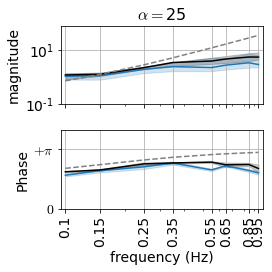

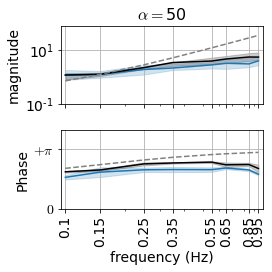

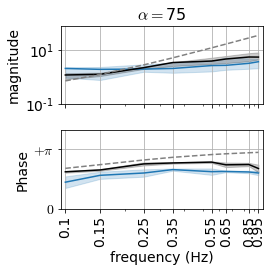

In [10]:
# Bode plot of F and B
xticks = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95])
xlim = (0.095, 1.0)
ylimphase = (0, np.pi+1)
yticksphase = [0.,np.pi]
yticklabelsphase = [r'$0$',r'$+\pi$']
last_few_trials = 5 # trial)num//2

for cond in [1,2,3]:
    fig,axs = plt.subplots(2,1,sharex=True,figsize=(4,4))

    # F1
    F_mean = np.mean(np.abs(F1[:,cond,-last_few_trials:,:]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(F_mean,[0.25,0.5,0.75],axis = 0) #across subjects
    # magnitude
    ax = axs[0]
    ax.plot(freqs,q50,'-',label = r'$F_1$, $\alpha = $'+conditions[cond],color = colors['BLUE'])
    ax.fill_between(freqs, q25, q75, alpha=0.2,color = colors['BLUE'])
    # phase
    ax = axs[1]
    F_angle = np.angle(np.mean(np.exp(1j*(np.angle(F1[:,cond,-last_few_trials:,:]))),axis = 1))
    z = np.mean(np.exp(1j*(F_angle-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-',label = r'$\alpha = $'+conditions[cond],color = colors['BLUE'])
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['BLUE'])

    # F_Manual-only
    F_mean = np.mean(np.abs(F1[:,0,-last_few_trials:,:]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(F_mean,[0.25,0.5,0.75],axis = 0)
    # magnitude
    ax = axs[0]
    ax.plot(freqs,q50,'-',label = r'$F_{Manual}$, $\alpha = $'+conditions[0],color = 'black')
    ax.fill_between(freqs, q25, q75, alpha=0.2,color = 'black')
    # phase
    ax = axs[1]
    F_angle = np.angle(np.mean(np.exp(1j*(np.angle(F1[:,0,-last_few_trials:,:]))),axis = 1))
    z = np.mean(np.exp(1j*(F_angle-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-',label = r'$\alpha = $'+conditions[0],color = 'black')
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = 'black')

    ax = axs[0]
    ax.plot(freqs,np.abs(1/M),'--',color= 'grey',label = r'$M^{-1}$')
    ax.set_xscale("log")
    ax.grid('on',zorder=-1)
    ax.set_ylim(0.1,80)
    ax.set_yscale("log")
    ax.set_ylabel('magnitude')
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    ax = axs[1]
    ax.plot(freqs,np.angle(1/M),'--',color= 'grey',label = r'$M^{-1}$')
    ax.set_ylabel('Phase') 
    ax.grid('on',zorder=-1)
    ax.set_xlim(xlim)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks,rotation=90) 
    ax.set_ylim(ylimphase)
    ax.set_yticks(yticksphase)
    ax.set_yticklabels(yticklabelsphase)
    ax.set_xlabel('frequency (Hz)')
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    # axs[0].set_title(r'Feedforward (N = 15), $\alpha = $'+conditions[cond])
    axs[0].set_title(r'$\alpha = $'+conditions[cond])
    plt.tight_layout()
    plt.show()

# condition 0.5

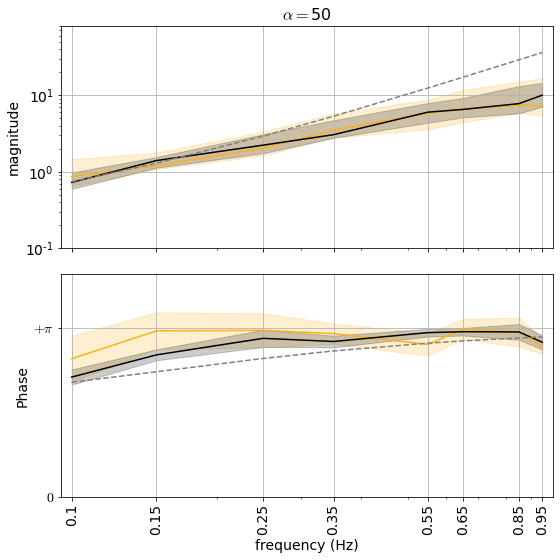

In [11]:
# Bode plot of F and B
xticks = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95])
xlim = (0.095, 1.0)
ylimphase = (0, np.pi+1)
yticksphase = [0.,np.pi]
yticklabelsphase = [r'$0$',r'$+\pi$']
last_few_trials = 5 # trial)num//2

cond = 2
fig,axs = plt.subplots(2,1,sharex=True,figsize=(8,8))

# F0
F_mean = np.mean(np.abs(F0[:,cond,-last_few_trials:,:]),axis = 1) #mean across all trials
q25,q50,q75 = np.quantile(F_mean,[0.25,0.5,0.75],axis = 0) #across subjects
# magnitude
ax = axs[0]
ax.plot(freqs,q50,'-',label = r'$F_0$, $\alpha = $'+conditions[cond],color = colors['GOLD'])
ax.fill_between(freqs, q25, q75, alpha=0.2,color = colors['GOLD'])
# phase
ax = axs[1]
F_angle = np.angle(np.mean(np.exp(1j*(np.angle(F0[:,cond,-last_few_trials:,:]))),axis = 1))
z = np.mean(np.exp(1j*(F_angle-np.pi/2)), axis=0)
mean = np.angle(z)+np.pi/2
disp = 1 - np.abs(z)
ax.plot(freqs,mean,'-',label = r'$\alpha = $'+conditions[cond],color = colors['GOLD'])
ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['GOLD'])

# F_EMG-only
F_mean = np.mean(np.abs(F[:,4,-last_few_trials:,:]),axis = 1) #mean across all trials
q25,q50,q75 = np.quantile(F_mean,[0.25,0.5,0.75],axis = 0)
# magnitude
ax = axs[0]
ax.plot(freqs,q50,'-',label = r'$F_{EMG}$, $\alpha = $'+conditions[4],color = 'black')
ax.fill_between(freqs, q25, q75, alpha=0.2,color = 'black')
# phase
ax = axs[1]
F_angle = np.angle(np.mean(np.exp(1j*(np.angle(F[:,4,-last_few_trials:,:]))),axis = 1))
z = np.mean(np.exp(1j*(F_angle-np.pi/2)), axis=0)
mean = np.angle(z)+np.pi/2
disp = 1 - np.abs(z)
ax.plot(freqs,mean,'-',label = r'$\alpha = $'+conditions[4],color = 'black')
ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = 'black')

ax = axs[0]
ax.plot(freqs,np.abs(1/M),'--',color= 'grey',label = r'$M^{-1}$')
ax.set_xscale("log")
ax.grid('on',zorder=-1)
ax.set_ylim(0.1,80)
ax.set_yscale("log")
ax.set_ylabel('magnitude')
# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

ax = axs[1]
ax.plot(freqs,np.angle(1/M),'--',color= 'grey',label = r'$M^{-1}$')
ax.set_ylabel('Phase') 
ax.grid('on',zorder=-1)
ax.set_xlim(xlim)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,rotation=90) 
ax.set_ylim(ylimphase)
ax.set_yticks(yticksphase)
ax.set_yticklabels(yticklabelsphase)
ax.set_xlabel('frequency (Hz)')
# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
# axs[0].set_title(r'Feedforward (N = 15), $\alpha = $'+conditions[cond])
axs[0].set_title(r'$\alpha = $'+conditions[cond])
plt.tight_layout()
plt.show()

In [12]:
cond = 2
F_mean2 = np.mean(np.abs(F0[:,cond,-last_few_trials:,:]),axis = 1) #mean across all trials
# F_EMG-only
F_mean = np.mean(np.abs(F[:,4,-last_few_trials:,:]),axis = 1) #mean across all trials
for i in range(8):
    stat, p = wilcoxon(F_mean2[:,i], F_mean[:,i])
    print(f'Wilcoxon Test Statistic={stat:.4f}, p-value={p:.4f}') # If p < 0.05, there is a significant difference
print('\n')
F_mean2 = np.mean(np.abs(F1[:,cond,-last_few_trials:,:]),axis = 1) #mean across all trials
# manual-only
F_mean = np.mean(np.abs(F[:,0,-last_few_trials:,:]),axis = 1) #mean across all trials
for i in range(8):
    stat, p = wilcoxon(F_mean2[:,i], F_mean[:,i])
    print(f'Wilcoxon Test Statistic={stat:.4f}, p-value={p:.4f}') # If p < 0.05, there is a significant difference

Wilcoxon Test Statistic=47.0000, p-value=0.4887
Wilcoxon Test Statistic=60.0000, p-value=1.0000
Wilcoxon Test Statistic=54.0000, p-value=0.7615
Wilcoxon Test Statistic=44.0000, p-value=0.3894
Wilcoxon Test Statistic=57.0000, p-value=0.8904
Wilcoxon Test Statistic=59.0000, p-value=0.9780
Wilcoxon Test Statistic=47.0000, p-value=0.4887
Wilcoxon Test Statistic=54.0000, p-value=0.7615


Wilcoxon Test Statistic=57.0000, p-value=0.8904
Wilcoxon Test Statistic=47.0000, p-value=0.4887
Wilcoxon Test Statistic=45.0000, p-value=0.4212
Wilcoxon Test Statistic=15.0000, p-value=0.0084
Wilcoxon Test Statistic=22.0000, p-value=0.0302
Wilcoxon Test Statistic=21.0000, p-value=0.0256
Wilcoxon Test Statistic=6.0000, p-value=0.0009
Wilcoxon Test Statistic=29.0000, p-value=0.0833


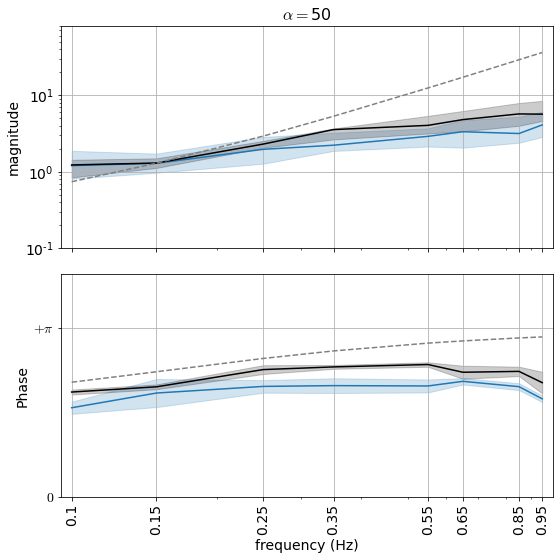

In [13]:
# Bode plot of F and B
xticks = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95])
xlim = (0.095, 1.0)
ylimphase = (0, np.pi+1)
yticksphase = [0.,np.pi]
yticklabelsphase = [r'$0$',r'$+\pi$']
last_few_trials = 5 # trial)num//2

cond = 2
fig,axs = plt.subplots(2,1,sharex=True,figsize=(8,8))

# F1
F_mean = np.mean(np.abs(F1[:,cond,-last_few_trials:,:]),axis = 1) #mean across all trials
q25,q50,q75 = np.quantile(F_mean,[0.25,0.5,0.75],axis = 0) #across subjects
# magnitude
ax = axs[0]
ax.plot(freqs,q50,'-',label = r'$F_1$, $\alpha = $'+conditions[cond],color = colors['BLUE'])
ax.fill_between(freqs, q25, q75, alpha=0.2,color = colors['BLUE'])
# phase
ax = axs[1]
F_angle = np.angle(np.mean(np.exp(1j*(np.angle(F1[:,cond,-last_few_trials:,:]))),axis = 1))
z = np.mean(np.exp(1j*(F_angle-np.pi/2)), axis=0)
mean = np.angle(z)+np.pi/2
disp = 1 - np.abs(z)
ax.plot(freqs,mean,'-',label = r'$\alpha = $'+conditions[cond],color = colors['BLUE'])
ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['BLUE'])

# F_Manual-only
F_mean = np.mean(np.abs(F1[:,0,-last_few_trials:,:]),axis = 1) #mean across all trials
q25,q50,q75 = np.quantile(F_mean,[0.25,0.5,0.75],axis = 0)
# magnitude
ax = axs[0]
ax.plot(freqs,q50,'-',label = r'$F_{Manual}$, $\alpha = $'+conditions[0],color = 'black')
ax.fill_between(freqs, q25, q75, alpha=0.2,color = 'black')
# phase
ax = axs[1]
F_angle = np.angle(np.mean(np.exp(1j*(np.angle(F1[:,0,-last_few_trials:,:]))),axis = 1))
z = np.mean(np.exp(1j*(F_angle-np.pi/2)), axis=0)
mean = np.angle(z)+np.pi/2
disp = 1 - np.abs(z)
ax.plot(freqs,mean,'-',label = r'$\alpha = $'+conditions[0],color = 'black')
ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = 'black')

ax = axs[0]
ax.plot(freqs,np.abs(1/M),'--',color= 'grey',label = r'$M^{-1}$')
ax.set_xscale("log")
ax.grid('on',zorder=-1)
ax.set_ylim(0.1,80)
ax.set_yscale("log")
ax.set_ylabel('magnitude')
# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

ax = axs[1]
ax.plot(freqs,np.angle(1/M),'--',color= 'grey',label = r'$M^{-1}$')
ax.set_ylabel('Phase') 
ax.grid('on',zorder=-1)
ax.set_xlim(xlim)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,rotation=90) 
ax.set_ylim(ylimphase)
ax.set_yticks(yticksphase)
ax.set_yticklabels(yticklabelsphase)
ax.set_xlabel('frequency (Hz)')
# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
# axs[0].set_title(r'Feedforward (N = 15), $\alpha = $'+conditions[cond])
axs[0].set_title(r'$\alpha = $'+conditions[cond])
plt.tight_layout()
plt.show()

In [14]:
# stats test on phase
# phase
cond = 2

angle2 = np.angle(np.mean(np.exp(1j*(np.angle(F0[:,cond,-last_few_trials:,:])-np.pi/2)),axis = 1))+np.pi/2
# z = np.mean(np.exp(1j*(F_angle-np.pi/2)), axis=0)
# mean = np.angle(z)+np.pi/2
# disp = 1 - np.abs(z)

angle4 = np.angle(np.mean(np.exp(1j*(np.angle(F[:,4,-last_few_trials:,:])-np.pi/2)),axis = 1))+np.pi/2
# z = np.mean(np.exp(1j*(F_angle-np.pi/2)), axis=0)
# mean = np.angle(z)+np.pi/2
# disp = 1 - np.abs(z)
for i in range(8):
    stat, p = wilcoxon(angle2[:,i], angle4[:,i])
    print(f'Wilcoxon Test Statistic={stat:.4f}, p-value={p:.4f}') # If p < 0.05, there is a significant difference

Wilcoxon Test Statistic=56.0000, p-value=0.8469
Wilcoxon Test Statistic=42.0000, p-value=0.3303
Wilcoxon Test Statistic=57.0000, p-value=0.8904
Wilcoxon Test Statistic=58.0000, p-value=0.9341
Wilcoxon Test Statistic=45.0000, p-value=0.4212
Wilcoxon Test Statistic=38.0000, p-value=0.2293
Wilcoxon Test Statistic=48.0000, p-value=0.5245
Wilcoxon Test Statistic=52.0000, p-value=0.6788


In [15]:
# stats test on phase
# phase
cond = 2

angle2 = np.angle(np.mean(np.exp(1j*(np.angle(F1[:,cond,-last_few_trials:,:])-np.pi/2)),axis = 1))+np.pi/2
# z = np.mean(np.exp(1j*(F_angle-np.pi/2)), axis=0)
# mean = np.angle(z)+np.pi/2
# disp = 1 - np.abs(z)


angle0 = np.angle(np.mean(np.exp(1j*(np.angle(F[:,0,-last_few_trials:,:])-np.pi/2)),axis = 1))+np.pi/2
# z = np.mean(np.exp(1j*(F_angle-np.pi/2)), axis=0)
# mean = np.angle(z)+np.pi/2
# disp = 1 - np.abs(z)
for i in range(8):
    stat, p = wilcoxon(angle2[:,i], angle0[:,i])
    print(f'Wilcoxon Test Statistic={stat:.4f}, p-value={p:.4f}') # If p < 0.05, there is a significant difference

Wilcoxon Test Statistic=25.0000, p-value=0.0479
Wilcoxon Test Statistic=49.0000, p-value=0.5614
Wilcoxon Test Statistic=23.0000, p-value=0.0353
Wilcoxon Test Statistic=16.0000, p-value=0.0103
Wilcoxon Test Statistic=16.0000, p-value=0.0103
Wilcoxon Test Statistic=38.0000, p-value=0.2293
Wilcoxon Test Statistic=4.0000, p-value=0.0004
Wilcoxon Test Statistic=28.0000, p-value=0.0730


# plot

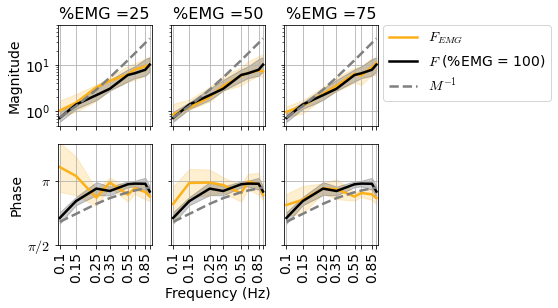

In [39]:
# Bode plot of F and B
xticks = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95])
xtickslabels = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, '', 0.85,''])
xlim = (0.095, 1.0)
ylimphase = (np.pi/2, np.pi+0.9)
yticksphase = [np.pi/2,np.pi]
yticklabelsphase = [r'$\pi/2$',r'$\pi$']
last_few_trials = 5 # trial)num//2
fig,axs = plt.subplots(2,3, sharex = 'col', sharey = 'row',figsize=(8,4.5))
for cond in [1,2,3]:
    # F0
    F_mean = np.mean(np.abs(F0[:,cond,-last_few_trials:,:]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(F_mean,[0.25,0.5,0.75],axis = 0) #across subjects
    # magnitude
    ax = axs[0,cond-1]
    ax.plot(freqs,q50,'-',label = r'$F_{EMG}$',color = colors['GOLD'],linewidth = 2.5)
    ax.fill_between(freqs, q25, q75, alpha=0.2,color = colors['GOLD'])
    # phase
    ax = axs[1,cond-1]
    F_angle = np.angle(np.mean(np.exp(1j*(np.angle(F0[:,cond,-last_few_trials:,:]))),axis = 1))
    z = np.mean(np.exp(1j*(F_angle-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-',label = r'$\alpha = $'+conditions[cond],color = colors['GOLD'],linewidth = 2.5)
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['GOLD'])

    # F_EMG-only
    F_mean = np.mean(np.abs(F0[:,4,-last_few_trials:,:]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(F_mean,[0.25,0.5,0.75],axis = 0)
    # magnitude
    ax = axs[0,cond-1]
    ax.plot(freqs,q50,'-',label = r'$F$ (%EMG = 100)',color = 'black',linewidth = 2.5)
    ax.fill_between(freqs, q25, q75, alpha=0.2,color = 'black')
    # phase
    ax = axs[1,cond-1]
    F_angle = np.angle(np.mean(np.exp(1j*(np.angle(F0[:,4,-last_few_trials:,:]))),axis = 1))
    z = np.mean(np.exp(1j*(F_angle-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-',label = r'$\alpha = $'+conditions[4],color = 'black',linewidth = 2.5)
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = 'black')

    ax = axs[0,cond-1]
    ax.plot(freqs,np.abs(1/M),'--',color= 'grey',label = r'$M^{-1}$',linewidth = 2.5)
    ax.set_xscale("log")
    ax.grid('on',zorder=-1)
    ax.set_ylim(0.5,70)
    ax.set_yscale("log")
    
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    ax = axs[1,cond-1]
    ax.plot(freqs,np.angle(1/M),'--',color= 'grey',label = r'$M^{-1}$',linewidth = 2.5)
    
    ax.grid('on',zorder=-1)
    ax.set_xlim(xlim)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xtickslabels,rotation=90) 
    ax.set_ylim(ylimphase)

    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    # axs[0].set_title(r'Feedforward (N = 15), $\alpha = $'+conditions[cond])
    axs[0,cond-1].set_title(r'%EMG ='+conditions[cond]) #($100*\alpha) 
axs[0,1].get_shared_x_axes().join(axs[0,0], axs[0,1])
axs[0,0].set_ylabel('Magnitude')
axs[1,0].set_ylabel('Phase') 
axs[1,1].set_xlabel('Frequency (Hz)')
axs[1,0].set_yticks(yticksphase)
axs[1,0].set_yticklabels(yticklabelsphase)
axs[0,2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
fig.savefig('ff_emg.svg')
plt.show()

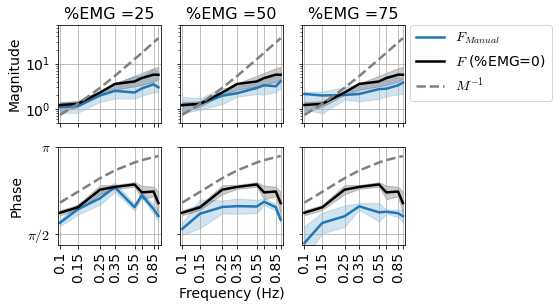

In [ ]:
# Bode plot of F and B
xticks = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95])
xtickslabels = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, '', 0.85,''])
xlim = (0.095, 1.0)
ylimphase = (np.pi/2-0.2, np.pi)
yticksphase = [np.pi/2,np.pi]
yticklabelsphase = [r'$\pi/2$',r'$\pi$']
last_few_trials = 5 # trial)num//2
fig,axs = plt.subplots(2,3, sharex = 'col', sharey = 'row',figsize=(8,4.5))
for cond in [1,2,3]:
    # F1
    F_mean = np.mean(np.abs(F1[:,cond,-last_few_trials:,:]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(F_mean,[0.25,0.5,0.75],axis = 0) #across subjects
    # magnitude
    ax = axs[0,cond-1]
    ax.plot(freqs,q50,'-',label = r'$F_{Manual}$',color = colors['BLUE'],linewidth = 2.5)
    ax.fill_between(freqs, q25, q75, alpha=0.2,color = colors['BLUE'])
    # phase
    ax = axs[1,cond-1]
    F_angle = np.angle(np.mean(np.exp(1j*(np.angle(F1[:,cond,-last_few_trials:,:]))),axis = 1))
    z = np.mean(np.exp(1j*(F_angle-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-',label = r'$\alpha = $'+conditions[cond],color = colors['BLUE'],linewidth = 2.5)
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['BLUE'])

    # F_Manual-only
    F_mean = np.mean(np.abs(F[:,0,-last_few_trials:,:]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(F_mean,[0.25,0.5,0.75],axis = 0)
    # magnitude
    ax = axs[0,cond-1]
    ax.plot(freqs,q50,'-',label = r'$F$ (%EMG=0)',color = 'black',linewidth = 2.5)
    ax.fill_between(freqs, q25, q75, alpha=0.2,color = 'black')
    # phase
    ax = axs[1,cond-1]
    F_angle = np.angle(np.mean(np.exp(1j*(np.angle(F[:,0,-last_few_trials:,:]))),axis = 1))
    z = np.mean(np.exp(1j*(F_angle-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-',label = r'$\alpha = $'+conditions[0],color = 'black',linewidth = 2.5)
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = 'black')

    ax = axs[0,cond-1]
    ax.plot(freqs,np.abs(1/M),'--',color= 'grey',label = r'$M^{-1}$',linewidth = 2.5)
    ax.set_xscale("log")
    ax.grid('on',zorder=-1)
    ax.set_ylim(0.5,70)
    ax.set_yscale("log")
    
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    ax = axs[1,cond-1]
    ax.plot(freqs,np.angle(1/M),'--',color= 'grey',label = r'$M^{-1}$',linewidth = 2.5)
    ax.grid('on',zorder=-1)
    ax.set_xlim(xlim)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xtickslabels,rotation=90) 
    ax.set_ylim(ylimphase)

    # ax.set_xlabel('Frequency (Hz)')
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    # axs[0].set_title(r'Feedforward (N = 15), $\alpha = $'+conditions[cond])
    axs[0,cond-1].set_title(r'%EMG ='+conditions[cond]) #($100*\alpha) 
axs[0,1].get_shared_x_axes().join(axs[0,0], axs[0,1])
axs[0,0].set_ylabel('Magnitude')
axs[1,0].set_ylabel('Phase') 
axs[1,1].set_xlabel('Frequency (Hz)')
axs[1,0].set_yticks(yticksphase)
axs[1,0].set_yticklabels(yticklabelsphase)
axs[0,2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
fig.savefig('ff_manual.svg')
plt.show()

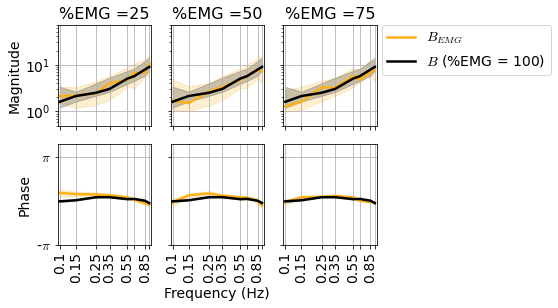

In [44]:
# Bode plot of F and B
xticks = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95])
xtickslabels = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, '', 0.85,''])
xlim = (0.095, 1.0)
ylimphase = (-np.pi, np.pi+0.9)
yticksphase = [-np.pi,np.pi]
yticklabelsphase = [r'-$\pi$',r'$\pi$']
last_few_trials = 5 # trial)num//2
fig,axs = plt.subplots(2,3, sharex = 'col', sharey = 'row',figsize=(8,4.5))
for cond in [1,2,3]:
    # F0
    F_mean = np.mean(np.abs(B0[:,cond,-last_few_trials:,:]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(F_mean,[0.25,0.5,0.75],axis = 0) #across subjects
    # magnitude
    ax = axs[0,cond-1]
    ax.plot(freqs,q50,'-',label = r'$B_{EMG}$',color = colors['GOLD'],linewidth = 2.5)
    ax.fill_between(freqs, q25, q75, alpha=0.2,color = colors['GOLD'])
    # phase
    ax = axs[1,cond-1]
    F_angle = np.angle(np.mean(np.exp(1j*(np.angle(B0[:,cond,-last_few_trials:,:]))),axis = 1))
    z = np.mean(np.exp(1j*(F_angle-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-',label = r'$\alpha = $'+conditions[cond],color = colors['GOLD'],linewidth = 2.5)
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['GOLD'])

    # F_EMG-only
    F_mean = np.mean(np.abs(B0[:,4,-last_few_trials:,:]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(F_mean,[0.25,0.5,0.75],axis = 0)
    # magnitude
    ax = axs[0,cond-1]
    ax.plot(freqs,q50,'-',label = r'$B$ (%EMG = 100)',color = 'black',linewidth = 2.5)
    ax.fill_between(freqs, q25, q75, alpha=0.2,color = 'black')
    # phase
    ax = axs[1,cond-1]
    F_angle = np.angle(np.mean(np.exp(1j*(np.angle(B0[:,4,-last_few_trials:,:]))),axis = 1))
    z = np.mean(np.exp(1j*(F_angle-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-',label = r'$\alpha = $'+conditions[4],color = 'black',linewidth = 2.5)
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = 'black')

    ax = axs[0,cond-1]
    # ax.plot(freqs,np.abs(1/M),'--',color= 'grey',label = r'$M^{-1}$',linewidth = 2.5)
    ax.set_xscale("log")
    ax.grid('on',zorder=-1)
    ax.set_ylim(0.5,70)
    ax.set_yscale("log")
    
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    ax = axs[1,cond-1]
    # ax.plot(freqs,np.angle(1/M),'--',color= 'grey',label = r'$M^{-1}$',linewidth = 2.5)
    
    ax.grid('on',zorder=-1)
    ax.set_xlim(xlim)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xtickslabels,rotation=90) 
    ax.set_ylim(ylimphase)

    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    # axs[0].set_title(r'Feedforward (N = 15), $\alpha = $'+conditions[cond])
    axs[0,cond-1].set_title(r'%EMG ='+conditions[cond]) #($100*\alpha) 
axs[0,1].get_shared_x_axes().join(axs[0,0], axs[0,1])
axs[0,0].set_ylabel('Magnitude')
axs[1,0].set_ylabel('Phase') 
axs[1,1].set_xlabel('Frequency (Hz)')
axs[1,0].set_yticks(yticksphase)
axs[1,0].set_yticklabels(yticklabelsphase)
axs[0,2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
# fig.savefig('ff_emg.svg')
plt.show()

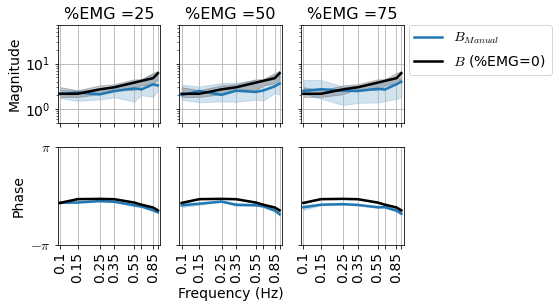

In [47]:
# Bode plot of F and B
xticks = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95])
xtickslabels = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, '', 0.85,''])
xlim = (0.095, 1.0)
ylimphase = (-np.pi, np.pi)
yticksphase = [-np.pi,np.pi]
yticklabelsphase = [r'$-\pi$',r'$\pi$']
last_few_trials = 5 # trial)num//2
fig,axs = plt.subplots(2,3, sharex = 'col', sharey = 'row',figsize=(8,4.5))
for cond in [1,2,3]:
    # F1
    F_mean = np.mean(np.abs(B1[:,cond,-last_few_trials:,:]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(F_mean,[0.25,0.5,0.75],axis = 0) #across subjects
    # magnitude
    ax = axs[0,cond-1]
    ax.plot(freqs,q50,'-',label = r'$B_{Manual}$',color = colors['BLUE'],linewidth = 2.5)
    ax.fill_between(freqs, q25, q75, alpha=0.2,color = colors['BLUE'])
    # phase
    ax = axs[1,cond-1]
    F_angle = np.angle(np.mean(np.exp(1j*(np.angle(B1[:,cond,-last_few_trials:,:]))),axis = 1))
    z = np.mean(np.exp(1j*(F_angle-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-',label = r'$\alpha = $'+conditions[cond],color = colors['BLUE'],linewidth = 2.5)
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['BLUE'])

    # F_Manual-only
    F_mean = np.mean(np.abs(B1[:,0,-last_few_trials:,:]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(F_mean,[0.25,0.5,0.75],axis = 0)
    # magnitude
    ax = axs[0,cond-1]
    ax.plot(freqs,q50,'-',label = r'$B$ (%EMG=0)',color = 'black',linewidth = 2.5)
    ax.fill_between(freqs, q25, q75, alpha=0.2,color = 'black')
    # phase
    ax = axs[1,cond-1]
    F_angle = np.angle(np.mean(np.exp(1j*(np.angle(B1[:,0,-last_few_trials:,:]))),axis = 1))
    z = np.mean(np.exp(1j*(F_angle-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-',label = r'$\alpha = $'+conditions[0],color = 'black',linewidth = 2.5)
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = 'black')

    ax = axs[0,cond-1]
    # ax.plot(freqs,np.abs(1/M),'--',color= 'grey',label = r'$M^{-1}$',linewidth = 2.5)
    ax.set_xscale("log")
    ax.grid('on',zorder=-1)
    ax.set_ylim(0.5,70)
    ax.set_yscale("log")
    
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    ax = axs[1,cond-1]
    # ax.plot(freqs,np.angle(1/M),'--',color= 'grey',label = r'$M^{-1}$',linewidth = 2.5)
    ax.grid('on',zorder=-1)
    ax.set_xlim(xlim)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xtickslabels,rotation=90) 
    ax.set_ylim(ylimphase)

    # ax.set_xlabel('Frequency (Hz)')
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    # axs[0].set_title(r'Feedforward (N = 15), $\alpha = $'+conditions[cond])
    axs[0,cond-1].set_title(r'%EMG ='+conditions[cond]) #($100*\alpha) 
axs[0,1].get_shared_x_axes().join(axs[0,0], axs[0,1])
axs[0,0].set_ylabel('Magnitude')
axs[1,0].set_ylabel('Phase') 
axs[1,1].set_xlabel('Frequency (Hz)')
axs[1,0].set_yticks(yticksphase)
axs[1,0].set_yticklabels(yticklabelsphase)
axs[0,2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
# fig.savefig('ff_manual.svg')
plt.show()

# boxplots F

In [22]:
datas = []
last_trials = 5 # 10//2
stim_below = 3

TF = F[:,:,-last_trials:,:stim_below]  #at stim below 0.25 Hz
for cond in range(condition_num):
    datas.append( np.mean((np.abs(TF[:,cond,:,:]))**2, axis = (1,2)) )#mean across all trials and freqs
stats_test(datas)

Shapiro-Wilk Test Statistic=0.6985, p-value=0.0000
Residuals are NOT normally distributed (reject H0).
Friedman Test Statistic=17.5467, p-value=0.0015
Friedman Test: significant difference
25 vs. 0: Raw p-value = 0.0012, Bonferroni-corrected p-value = 0.0070
50 vs. 0: Raw p-value = 0.0001, Bonferroni-corrected p-value = 0.0004
75 vs. 0: Raw p-value = 0.2524, Bonferroni-corrected p-value = 1.0000
25 vs. 100: Raw p-value = 0.1070, Bonferroni-corrected p-value = 0.6420
50 vs. 100: Raw p-value = 0.0479, Bonferroni-corrected p-value = 0.2875
75 vs. 100: Raw p-value = 0.6387, Bonferroni-corrected p-value = 1.0000


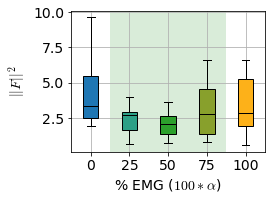

In [23]:
labels = conditions #slider : EMG
boxcolors = [colors['BLUE'],'#2ca086',colors['GREEN'],'#88a02c',colors['GOLD']]

fig,ax = plt.subplots(figsize=(4,3))
bplot = ax.boxplot(datas, widths = 0.4,patch_artist=True,labels=labels, showfliers=False)
for patch, color in zip(bplot['boxes'], boxcolors): # fill with colors
    patch.set_facecolor(color)
for median in bplot['medians']:
    median.set_color('black')
# ax.set_xlabel('Manual : EMG',fontsize = 14) #add x axis labels
ax.set_xlabel(r'% EMG ($100*\alpha$)',fontsize = 14) #add x axis labels
face0 = ax.axvspan(1.5,4.5, facecolor='green', alpha=0.15)
ax.set_ylabel(r'$||F||^2$',fontsize = 14) # add y axis label
ax.grid('on',zorder=-1)
# ax.set_title('average |R-Y| below crossover freqs (N = 15)')
plt.tight_layout()
# fig.savefig('example_sub1.svg')
plt.show()

In [24]:
# Conduct the one-way ANOVA
f_oneway(datas[0],datas[1],datas[2],datas[3],datas[4]) #see if p < 0.05

F_onewayResult(statistic=1.7464980095078366, pvalue=0.14954951577026868)

# bosplot B

In [30]:
datas = []
last_trials = 5 # 10//2
stim_below = 3

TF = B[:,:,-last_trials:,:stim_below]  #at stim below 0.25 Hz
for cond in range(condition_num):
    datas.append( np.mean((np.abs(TF[:,cond,:,:]))**2, axis = (1,2)) )#mean across all trials and freqs
stats_test(datas)

Shapiro-Wilk Test Statistic=0.2875, p-value=0.0000
Residuals are NOT normally distributed (reject H0).
Friedman Test Statistic=4.1600, p-value=0.3848
Friedman Test: no significant difference


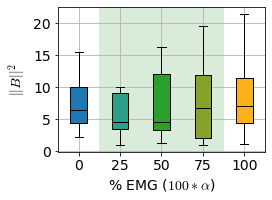

In [31]:
labels = conditions #slider : EMG
boxcolors = [colors['BLUE'],'#2ca086',colors['GREEN'],'#88a02c',colors['GOLD']]

fig,ax = plt.subplots(figsize=(4,3))
bplot = ax.boxplot(datas, widths = 0.4,patch_artist=True,labels=labels, showfliers=False)
for patch, color in zip(bplot['boxes'], boxcolors): # fill with colors
    patch.set_facecolor(color)
for median in bplot['medians']:
    median.set_color('black')
# ax.set_xlabel('Manual : EMG',fontsize = 14) #add x axis labels
ax.set_xlabel(r'% EMG ($100*\alpha$)',fontsize = 14) #add x axis labels
face0 = ax.axvspan(1.5,4.5, facecolor='green', alpha=0.15)
ax.set_ylabel(r'$||B||^2$',fontsize = 14) # add y axis label
ax.grid('on',zorder=-1)
# ax.set_title('average |R-Y| below crossover freqs (N = 15)')
plt.tight_layout()
# fig.savefig('example_sub1.svg')
plt.show()

# boxplots F0

In [25]:
datas = []
last_trials = 5 # 10//2
stim_below = 3

TF = F0[:,:,-last_trials:,:stim_below] #at stim below 0.25 Hz
for cond in range(condition_num):
    datas.append( np.mean((np.abs(TF[:,cond,:,:]))**2, axis = (1,2)) )#mean across all trials and freqs
stats_test(datas)
datas = datas[1:]


Shapiro-Wilk Test Statistic=0.6945, p-value=0.0000
Residuals are NOT normally distributed (reject H0).
Friedman Test Statistic=13.9200, p-value=0.0076
Friedman Test: significant difference
25 vs. 0: Raw p-value = 0.0043, Bonferroni-corrected p-value = 0.0256
50 vs. 0: Raw p-value = 0.0215, Bonferroni-corrected p-value = 0.1293
75 vs. 0: Raw p-value = 0.0125, Bonferroni-corrected p-value = 0.0747
25 vs. 100: Raw p-value = 0.3591, Bonferroni-corrected p-value = 1.0000
50 vs. 100: Raw p-value = 0.8904, Bonferroni-corrected p-value = 1.0000
75 vs. 100: Raw p-value = 0.6387, Bonferroni-corrected p-value = 1.0000


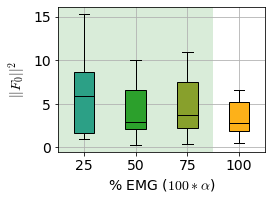

In [26]:
labels = conditions[1:] #slider : EMG
boxcolors = ['#2ca086',colors['GREEN'],'#88a02c',colors['GOLD']]

fig,ax = plt.subplots(figsize=(4,3))
bplot = ax.boxplot(datas, widths = 0.4,patch_artist=True,labels=labels, showfliers=False)
for patch, color in zip(bplot['boxes'], boxcolors): # fill with colors
    patch.set_facecolor(color)
for median in bplot['medians']:
    median.set_color('black')
# ax.set_xlabel('Manual : EMG',fontsize = 14) #add x axis labels
ax.set_xlabel(r'% EMG ($100*\alpha$)',fontsize = 14) #add x axis labels
face0 = ax.axvspan(0.5,3.5, facecolor='green', alpha=0.15)
ax.set_ylabel(r'$||F_0||^2$',fontsize = 14) # add y axis label
ax.grid('on',zorder=-1)
# ax.set_title('average |R-Y| below crossover freqs (N = 15)')
plt.tight_layout()
# fig.savefig('example_sub1.svg')
plt.show()

In [27]:
# Conduct the one-way ANOVA
f_oneway(datas[0],datas[1],datas[2],datas[3]) #see if p < 0.05

F_onewayResult(statistic=0.7105522483519394, pvalue=0.5497773086383017)

# boxplots F1

In [28]:
datas = []
last_trials = 5 # 10//2
stim_below = 3

TF = F1[:,:,-last_trials:,:stim_below] #at stim below 0.25 Hz
for cond in range(condition_num):
    datas.append( np.mean((np.abs(TF[:,cond,:,:]))**2, axis = (1,2)) )#mean across all trials and freqs
stats_test(datas)
datas = datas[:-1]

Shapiro-Wilk Test Statistic=0.9371, p-value=0.0010
Residuals are NOT normally distributed (reject H0).
Friedman Test Statistic=38.6667, p-value=0.0000
Friedman Test: significant difference
25 vs. 0: Raw p-value = 0.0125, Bonferroni-corrected p-value = 0.0747
50 vs. 0: Raw p-value = 0.1070, Bonferroni-corrected p-value = 0.6420
75 vs. 0: Raw p-value = 0.3894, Bonferroni-corrected p-value = 1.0000
25 vs. 100: Raw p-value = 0.0001, Bonferroni-corrected p-value = 0.0004
50 vs. 100: Raw p-value = 0.0001, Bonferroni-corrected p-value = 0.0004
75 vs. 100: Raw p-value = 0.0001, Bonferroni-corrected p-value = 0.0004


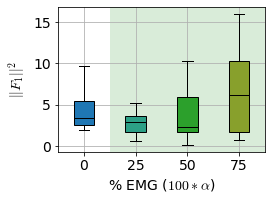

In [29]:
labels = conditions[:-1] #slider : EMG
boxcolors = [colors['BLUE'],'#2ca086',colors['GREEN'],'#88a02c']

fig,ax = plt.subplots(figsize=(4,3))
bplot = ax.boxplot(datas, widths = 0.4,patch_artist=True,labels=labels, showfliers=False)
for patch, color in zip(bplot['boxes'], boxcolors): # fill with colors
    patch.set_facecolor(color)
for median in bplot['medians']:
    median.set_color('black')
# ax.set_xlabel('Manual : EMG',fontsize = 14) #add x axis labels
ax.set_xlabel(r'% EMG ($100*\alpha$)',fontsize = 14) #add x axis labels
face0 = ax.axvspan(1.5,4.5, facecolor='green', alpha=0.15)
ax.set_ylabel(r'$||F_1||^2$',fontsize = 14) # add y axis label
ax.grid('on',zorder=-1)
# ax.set_title('average |R-Y| below crossover freqs (N = 15)')
plt.tight_layout()
# fig.savefig('example_sub1.svg')
plt.show()

In [107]:
# Conduct the one-way ANOVA
f_oneway(datas[0],datas[1],datas[2],datas[3]) #see if p < 0.05

F_onewayResult(statistic=3.378429632539739, pvalue=0.02445213681884442)